In [1]:
#https://www.kaggle.com/code/simplyab/nba-hall-of-famers-2021-csv (kaggle dataset)
import pandas as pd 
import numpy as np
import hvplot.pandas
from pathlib import Path

In [2]:
file_path = Path('./NBA Hall of Famers 2021.csv')
df_hof = pd.read_csv(file_path)
df_hof.head()

,Name,position,All_star_selections,In_Hall_of_fame,height,weight,born
0,Larry Foust,C,8,0,206,97,1928
1,Brad Daugherty,C,5,0,213,111,1965
2,Bill Laimbeer,C,4,0,211,111,1957
3,Red Kerr,C,3,0,206,104,1932
4,Red Rocha,C,2,0,206,83,1923


In [3]:
# Remove active players (players who have a value of 2 in the Hall of Fame column)
df_hof = df_hof[df_hof['In_Hall_of_fame'] != 2]

In [4]:
# Check to see if all duplicates are removed 
df_hof.duplicated().sum()

0

In [5]:
# Check how many hall of famers and non hall of famers there are in the dataset 
df_hof['In_Hall_of_fame'].value_counts()

In_Hall_of_fame
0    244
1    130
Name: count, dtype: int64

array([[<Axes: title={'center': 'All_star_selections'}>,
        <Axes: title={'center': 'In_Hall_of_fame'}>],
       [<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'weight'}>],
       [<Axes: title={'center': 'born'}>, <Axes: >]], dtype=object)

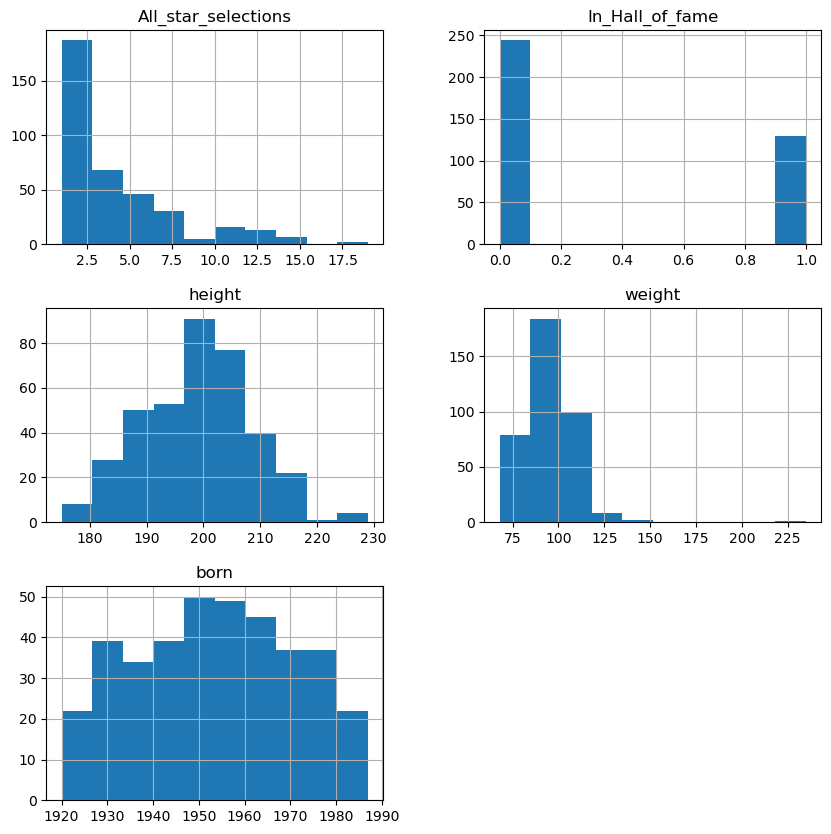

In [6]:
# Check to see if data has Gaussian Distribution 
# Histogram for visual check 
df_hof.hist(figsize= (10,10))

In [7]:
# Shapiro-Wilk Test for normality
from scipy.stats import shapiro
norm_test_df = df_hof[['All_star_selections', 'In_Hall_of_fame', 'height', 'weight', 'born']]
for column in norm_test_df.columns:
    if shapiro(df_hof[column])[1] <0.05:
        print(f"{column} is not Gaussian.")
    else:
        print(f"{column} is Gaussian.")


All_star_selections is not Gaussian.
In_Hall_of_fame is not Gaussian.
height is not Gaussian.
weight is not Gaussian.
born is not Gaussian.


In [8]:
#Kolmogorov-Smirnov Test for normality
from scipy.stats import kstest
for column in norm_test_df.columns:
    p_value = kstest(norm_test_df[column], 'norm')[1]
    if p_value < 0.05:
        print(f"{column} is not Gaussian.")
    else:
        print(f"{column} is Gaussian.")

All_star_selections is not Gaussian.
In_Hall_of_fame is not Gaussian.
height is not Gaussian.
weight is not Gaussian.
born is not Gaussian.


In [9]:
# One-hot encoder for categorical data 
from sklearn.preprocessing import OneHotEncoder
df_hof['position'].value_counts()
encoder = OneHotEncoder(handle_unknown= 'ignore', sparse_output= False)
encoded_array = encoder.fit_transform(df_hof[['position']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['position']))
normalized_data_df = pd.concat([norm_test_df, encoded_df], axis=1)
normalized_data_df.head()

,All_star_selections,In_Hall_of_fame,height,weight,born,position_C,position_F,position_G
0,8,0,206,97,1928,1.0,0.0,0.0
1,5,0,213,111,1965,1.0,0.0,0.0
2,4,0,211,111,1957,1.0,0.0,0.0
3,3,0,206,104,1932,1.0,0.0,0.0
4,2,0,206,83,1923,1.0,0.0,0.0


In [20]:
#Split up Data 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
X = normalized_data_df.copy().drop(columns= 'In_Hall_of_fame', axis=1)
y = normalized_data_df['In_Hall_of_fame']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 78, stratify= y)


In [11]:
#Using Minxmaxscaler() because data is not Gaussian 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [12]:
# Logistic Regression Model w/ newton-cg solver
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='newton-cg', random_state= 78)
lr_model.fit(X_train_scaled,y_train)
print(f" Training data score: {lr_model.score(X_train_scaled, y_train)}")
print(f" Testing data score: {lr_model.score(X_test_scaled, y_test)}", end="\n\n")
lr_predictions = lr_model.predict(X_test_scaled)
lr_pred_actual_df = pd.DataFrame({"Prediction": lr_predictions,"Actual Value": y_test})
print(lr_pred_actual_df.head(), end="\n\n")

#Accuracy Score
lr_model_ac = accuracy_score(y_test, lr_predictions)
print(f"Logistic regression model w/ newton-cg solver's accuracy score is: {lr_model_ac}", end="\n\n")

#Classification Report 
print(f'Classification report:\n\n{classification_report(y_test, lr_predictions, target_names= ["HOF", "Not HOF"])}')

#Confusion Matrix 
cm = confusion_matrix(y_test, lr_predictions)
cm_df = pd.DataFrame(
    cm, index = ["Actual 0", "Acutal 1"], columns = ["Predicted 0", "Predicted 1"]
)
print(f'Confusion Matrix:\n\n{cm_df}')

# Aggregates for the confusion matrix match so we can consider this model to be an accurate model. 
      

 Training data score: 0.8535714285714285
 Testing data score: 0.8297872340425532

     Prediction  Actual Value
219           0             0
127           0             0
262           1             1
217           0             0
102           0             0

Logistic regression model w/ newton-cg solver's accuracy score is: 0.8297872340425532

Classification report:

              precision    recall  f1-score   support

         HOF       0.80      0.98      0.88        61
     Not HOF       0.95      0.55      0.69        33

    accuracy                           0.83        94
   macro avg       0.87      0.76      0.79        94
weighted avg       0.85      0.83      0.82        94

Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0           60            1
Acutal 1           15           18


In [13]:
# Logistic Regression Model w/ lbfgs solver
lr_model_2 = LogisticRegression(solver='lbfgs', random_state= 78)
lr_model_2.fit(X_train_scaled,y_train)
print(f" Training data score: {lr_model_2.score(X_train_scaled, y_train)}")
print(f" Testing data score: {lr_model_2.score(X_test_scaled, y_test)}", end="\n\n")
lr_predictions_2 = lr_model_2.predict(X_test_scaled)

#Dataframe with predicted and actual 
lr_pred_actual_df_2 = pd.DataFrame({"Prediction": lr_predictions_2,"Actual Value": y_test})
print(lr_pred_actual_df_2.head(), end="\n\n")

#Accuracy Score
lr_model_ac_2 = accuracy_score(y_test, lr_predictions)
print(f"Logistic regression model w/ lbfgs solver's accuracy score is: {lr_model_ac_2}", end="\n\n")

#Classification Report 
print(f'Classification report:\n\n{classification_report(y_test, lr_predictions_2, target_names= ["HOF", "Not HOF"])}')

#Confusion Matrix 
cm_2 = confusion_matrix(y_test, lr_predictions_2)
cm_df_2 = pd.DataFrame(
    cm_2, index = ["Actual 0", "Actual 1"], columns = ["Predicted 0", "Predicted 1"]
)
print(f'Confusion Matrix:\n\n{cm_df}')

# Aggregates for the confusion matrix match so we can consider this model to be an accurate model. 

 Training data score: 0.8535714285714285
 Testing data score: 0.8297872340425532

     Prediction  Actual Value
219           0             0
127           0             0
262           1             1
217           0             0
102           0             0

Logistic regression model w/ lbfgs solver's accuracy score is: 0.8297872340425532

Classification report:

              precision    recall  f1-score   support

         HOF       0.80      0.98      0.88        61
     Not HOF       0.95      0.55      0.69        33

    accuracy                           0.83        94
   macro avg       0.87      0.76      0.79        94
weighted avg       0.85      0.83      0.82        94

Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0           60            1
Acutal 1           15           18


In [ ]:
# There was no observed difference between using a newton-cg or lbfgs solver for the Logistic Regression Models 
# The accuracy scores for the logistic models were the same at around 83%. 

In [14]:
# SVM (support vector machine) Model 
from sklearn.svm import SVC
#SVC model's training and testing data score
svc_model = SVC(kernel= 'linear')
svc_model.fit(X_train_scaled, y_train)
svc_predictions = svc_model.predict(X_test_scaled)
print(f" Training data score: {svc_model.score(X_train_scaled, y_train)}")
print(f" Testing data score: {svc_model.score(X_test_scaled, y_test)}", end="\n\n")

#Dataframe with predicted and actual 
svc_pred_df = pd.DataFrame({"Predictions":svc_predictions, "Actual":y_test})
print(svc_pred_df.head(), end= '\n\n')

#SVC model accuracy score 
svc_acc = accuracy_score(y_test, svc_predictions)
print(f"SVC model's accuracy score is: {svc_acc}", end="\n\n")

#Classification Report 
svc_classification = classification_report(y_test, svc_predictions, target_names= ['HOF', 'Not HOF'])
print(f'Classification report:\n\n{svc_classification}')

#Confusion Matrix 
svc_cm = confusion_matrix(y_test, svc_predictions)
svc_cm_df = pd.DataFrame(
    svc_cm, index = ['Actual 0', 'Actual 1'], columns = ["Predicted 0", "Predicted 1"]
)
print(f'Confusion Matrix:\n\n{svc_cm_df}')

 Training data score: 0.8571428571428571
 Testing data score: 0.8617021276595744

     Predictions  Actual
219            0       0
127            0       0
262            1       1
217            0       0
102            0       0

SVC model's accuracy score is: 0.8617021276595744

Classification report:

              precision    recall  f1-score   support

         HOF       0.84      0.97      0.90        61
     Not HOF       0.92      0.67      0.77        33

    accuracy                           0.86        94
   macro avg       0.88      0.82      0.84        94
weighted avg       0.87      0.86      0.86        94

Confusion Matrix:

          Predicted 0  Predicted 1
Actual 0           59            2
Actual 1           11           22


In [15]:
# Naive Bayes Classifier 
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_predictions = nb_model.predict(X_test_scaled)
#Training and testing data score
print(f" Training data score: {nb_model.score(X_train_scaled, y_train)}")
print(f" Testing data score: {nb_model.score(X_test_scaled, y_test)}", end="\n\n")


 Training data score: 0.8178571428571428
 Testing data score: 0.6170212765957447



In [16]:
# K-Nearest Neighbors 
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier()
kn_model.fit(X_train_scaled, y_train)
kn_predictions = kn_model.predict(X_test_scaled)
print(f"K-Nearest Neighbors model's accuracy score is: {accuracy_score(y_test, kn_predictions)}")

K-Nearest Neighbors model's accuracy score is: 0.8085106382978723


In [17]:
#Decision Tree 
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train_scaled, y_train)
tree_predictions = tree_model.predict(X_test_scaled)
print(f"Decision Tree model's accuracy score is: {accuracy_score(y_test, tree_predictions)}")

Decision Tree model's accuracy score is: 0.7446808510638298


In [23]:
#Neural Network 
import tensorflow as tf 
nn_model = tf.keras.models.Sequential()

#Input Layer and Output Layer 
nn_model.add(tf.keras.layers.Dense(units=50, activation= 'relu', input_dim = 7))
nn_model.add(tf.keras.layers.Dense(units=1, activation= 'sigmoid'))

#Summary of nn model 
nn_model.summary()

#Model Compilation 
nn_model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

fit_model = nn_model.fit(X_train_scaled, y_train, epochs = 100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                400       
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 451 (1.76 KB)
Trainable params: 451 (1.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 3s 9ms/step - loss: 0.6889 - accuracy: 0.6071
Epoch 2/100
9/9 [==============================] - 0s 12ms/step - loss: 0.6694 - accuracy: 0.6429
Epoch 3/100
9/9 [==============================] - 0s 12ms/step - loss: 0.6535 - accuracy: 0.6571
Epoch 4/100
9/9 [==============================] - 0s 10ms/step - loss: 0.6395 - accuracy: 0.6571
Epoch 5/100
9/9 [============

In [24]:
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose = 2)

3/3 - 0s - loss: 0.3426 - accuracy: 0.8617 - 383ms/epoch - 128ms/step
